Universidad del valle de Guatemala  
Dpto. Ciencias de la computacion  
Inteligencia Artificial  
Alberto Suriano  

Laboratorio 5  
Andres Quinto - 18288  
Marlon Hernández - 15177  

- Link del repositorio:https://github.com/AndresQuinto5/IA_LAB5.git

In [16]:
import struct
import mmap
import numpy as np, numpy
import time
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from numpy import frombuffer             
from collections import deque                           
import heapq

In [17]:

class Readbmp(object):
    def __init__(self, path):
        self.path = path
        self.fraction = 80
        self.matrix = []
        self.read()
        self.generateMatrix()
        self.generateMatrixZeros()
        self.discretization()

    def color(self, r, g, b):
        return bytes([b, g, r])

    def read(self):
        with open(self.path, "rb") as img:
            m = mmap.mmap(img.fileno(), 0, access=mmap.ACCESS_READ)
            ba = bytearray(m)
            self.width = struct.unpack("=l", ba[18:22])[0]
            self.height = struct.unpack("=l", ba[22:26])[0]
            
            # Cálculo de padding
            padding = (4 - (self.width * 3) % 4) % 4
            
            header_size = struct.unpack("=l", ba[10:14])[0]
            all_bytes = ba[header_size:]
            
            self.pixels = []
            for row in range(self.height):
                row_start = row * (self.width * 3 + padding)
                row_end = row_start + (self.width * 3)
                self.pixels.append(all_bytes[row_start:row_end])

            # Convertir a numpy array y reorganizar a formato (height, width, 3)
            self.pixels = numpy.frombuffer(b''.join(self.pixels), dtype='uint8').reshape((self.height, self.width, 3))


    def generateMatrix(self):
        self.matrix = [[self.color(0, 0, 0) for x in range(self.fraction)] for y in range(self.fraction)]

    def generateMatrixZeros(self):
        self.maze = [[0 for x in range(self.fraction)] for y in range(self.fraction)]


    def set_borders(self):
    # Ensure the borders of the matrix are set to black
        border_color = self.color(0, 0, 0)  # Black color for borders
        for i in range(self.fraction):
            # Set the top and bottom borders
            self.matrix[0][i] = border_color
            self.matrix[self.fraction - 1][i] = border_color
            # Set the left and right borders
            self.matrix[i][0] = border_color
            self.matrix[i][self.fraction - 1] = border_color

    def discretization(self):
        """
        Discretizes the image into blocks and determines whether each block represents a path or an obstacle.

        This method divides the image into smaller blocks based on the specified fraction. It then analyzes each block
        to determine if it contains a path or an obstacle. The analysis is based on color thresholds and the proportion
        of pixels in the block that represent a path.

        Returns:
            None
        """
        step_size_x = self.height // self.fraction
        step_size_y = self.width // self.fraction

        # Reinicializa las coordenadas de inicio y final
        self.startCoor = None
        self.endingCoor = []

        # Umbral de similitud para el color verde claro
        green_threshold = np.array([5,252,6])  # en RGB
        green_threshold_bgr = green_threshold[::-1]  # en BGR
        red_threshold = np.array([254, 0, 0])  # en RGB
        red_threshold_bgr = red_threshold[::-1]  # en BGR
        dark_threshold = np.array([30, 30, 30])

        # Assume that dark colors are obstacles and light colors are paths
        # Here we assume any color with RGB values above a certain threshold is walkable
        path_color_threshold = 50  # Adjust threshold as needed
        
        for big_X in range(self.fraction):
            for big_Y in range(self.fraction):
                start_x = big_X * step_size_x
                end_x = min((big_X + 1) * step_size_x, self.height)
                start_y = big_Y * step_size_y
                end_y = min((big_Y + 1) * step_size_y, self.width)

                block = self.pixels[start_x:end_x, start_y:end_y]
                path_Counter = 0
                obstacle_Counter = 0

                start_Flag = False
                end_Flag = False

                # Revisar cada pixel en el bloque para detectar camino, inicio y fin
                for lil_x in range(block.shape[0]):
                    for lil_y in range(block.shape[1]):
                        pixel = block[lil_x, lil_y]

                        if np.any(pixel > path_color_threshold): #Detectar camino
                            path_Counter += 1

                        if np.all(pixel <= dark_threshold):  # Detectar obstáculos
                            obstacle_Counter += 1

                        # Verificar si el pixel actual es el punto de inicio
                        if np.all(pixel == red_threshold_bgr):
                            self.startCoor = (big_X, big_Y)
                            self.matrix[big_X][big_Y] = self.color(*red_threshold)  # Marcar inicio
                            break  # No es necesario buscar más en este bloque

                        # Verificar si el pixel actual es un punto de fin
                        elif np.all(np.abs(pixel - green_threshold_bgr) <= [10, 10, 10]):
                            if (big_X, big_Y) not in self.endingCoor:
                                self.endingCoor.append((big_X, big_Y))
                            self.matrix[big_X][big_Y] = self.color(*green_threshold)  # Marcar fin
                            break  # No es necesario buscar más en este bloque

                        # # Contar si el pixel es parte del camino
                        # elif np.all(pixel == [255, 255, 255]):
                        #     path_Counter += 1
                        # Determinar si el bloque es camino o obstáculo
                        total_pixels = block.shape[0] * block.shape[1]
                        if obstacle_Counter / total_pixels > 0.5:
                            self.maze[big_X][big_Y] = 1  # Marcar como obstáculo
                        else:
                            self.maze[big_X][big_Y] = 0  # Marcar como camino


                    # Si ya se marcó el bloque como inicio o fin, salir del bucle
                    if self.matrix[big_X][big_Y] in [self.color(*red_threshold), self.color(*green_threshold)]:
                        break
                
                # Calculate the proportion of the path in the block
                total_pixels = block.shape[0] * block.shape[1]
                proportion = path_Counter / total_pixels if total_pixels else 0

                # Si el bloque no ha sido marcado como inicio o fin, determinar si es camino o obstáculo
                if self.matrix[big_X][big_Y] not in [self.color(*red_threshold), self.color(*green_threshold)]:
                    total_pixels = block.shape[0] * block.shape[1]
                    proportion = path_Counter / total_pixels if total_pixels else 0


                    if proportion >= 0.5:
                            self.matrix[big_X][big_Y] = self.color(255, 255, 255)  # Mayoritariamente camino
                    else:
                        self.matrix[big_X][big_Y] = self.color(0, 0, 0)  # Mayoritariamente obstáculo
        # print(self.maze)
        self.set_borders()

    def bfs(self):
        """
        Performs breadth-first search to find the shortest path from start to end.

        Returns:
            list: The shortest path as a list of coordinates, or an empty list if no path is found.
        """
        if not self.startCoor or not self.endingCoor:
            print("Start or end coordinates not defined")
            return []

        queue = deque([self.startCoor])
        visited = {self.startCoor: None}  # Dictionary to keep track of the path

        while queue:
            current = queue.popleft()
            if current in self.endingCoor:
                return self.reconstruct_path(visited, current)

            x, y = current
            for direction in [(0, 1), (1, 0), (0, -1), (-1, 0)]:  # Down, Right, Up, Left
                next_x, next_y = x + direction[0], y + direction[1]
                if (0 <= next_x < self.fraction and 0 <= next_y < self.fraction and
                        (next_x, next_y) not in visited and self.maze[next_x][next_y] == 0):
                    queue.append((next_x, next_y))
                    visited[(next_x, next_y)] = current

        return []  # No path found

    def reconstruct_path(self, visited, end):
        """
        Reconstructs the path from the end coordinate to the start using the visited dictionary.

        Args:
            visited (dict): The dictionary containing the visited coordinates.
            end (tuple): The end coordinate from where to start the reconstruction.

        Returns:
            list: The reconstructed path as a list of coordinates.
        """
        path = []
        while end is not None:
            path.append(end)
            end = visited[end]
        path.reverse()  # The path is reconstructed from end to start, so we reverse it
        return path

    def paint_path(self, path, color):
        """
        Paints the given path on the matrix with the given color.

        Args:
            path (list): The path as a list of coordinates.
            color (tuple): The color to paint the path with.
        """
        for x, y in path:
            if not (x == 0 or x == self.fraction - 1 or y == 0 or y == self.fraction - 1):
                self.matrix[x][y] = self.color(*color)
                # self.set_borders()

    def find_and_paint_path_bfs(self):
        """
        Finds the path using BFS and paints it on the matrix.
        """
        path = self.bfs()
        if path:
            # Paint the path with a color, e.g., gray
            self.paint_path(path, (128, 128, 128))
            # Optionally, ensure start and end are still colored correctly
            self.paint_path([self.startCoor], (254, 0, 0))  # Start color
            self.paint_path(self.endingCoor, (5, 252, 6))  # End color
        else:
            print("No path found")

    def dfs(self, current, visited=None, path=None, backtracked=None):
        """
        Performs depth-first search to find a path from start to end.

        Args:
            current (tuple): The current coordinates as a tuple (x, y).
            visited (set): A set of visited coordinates.
            path (list): The current path taken to reach the current coordinate.
            backtracked (list): The path segments that have been backtracked.

        Returns:
            bool: True if a path is found to an end, False otherwise.

        EXPLANATION:
        WHY in early stages dfs just interrupts the path?
        
        The interruptions in the path with the DFS algorithm can occur due to its nature; 
        it explores as far as possible along a branch and then backtracks. It could be that 
        the path is reaching a dead-end and then trying to find a new path from the last best 
        node, leading to disjointed segments in the maze.

        To ensure the DFS algorithm works correctly, we need to implement it in a way that it 
        marks the path as it goes along and unmarks it if it backtracks over a wrong path. 
        The "visited" set should be updated accordingly.
        """
        if visited is None:
            visited = set()
        if path is None:
            path = []
        if backtracked is None:
            backtracked = []

        # Skip the border cells.
        if current[0] == 0 or current[0] == self.fraction - 1 or current[1] == 0 or current[1] == self.fraction - 1:
            return None

        visited.add(current)
        path.append(current)  # Add the current cell to the path.

        if current in self.endingCoor:  # Check if current is the ending coordinate.
            return path

        # Explore all adjacent cells (down, right, up, left).
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        for dx, dy in directions:
            next_x, next_y = current[0] + dx, current[1] + dy
            if (0 < next_x < self.fraction - 1 and 0 < next_y < self.fraction - 1 and
                    (next_x, next_y) not in visited and self.maze[next_x][next_y] == 0):
                result = self.dfs((next_x, next_y), visited, path, backtracked)
                if result is not None:  # If a path is found, return it.
                    return result

        # If no path is found from the current node, backtrack.
        visited.remove(current)
        backtracked.append(path.pop())  # Add the backtracked node to the list.
        return None

    def find_and_paint_path_dfs(self):
        """
        Finds paths using DFS and paints them on the matrix.
        Successful paths are painted with one color, backtracked paths with another.
        """
        visited = set()
        path = []
        backtracked = []
        result = self.dfs(self.startCoor, visited, path, backtracked)

        # Paint the backtracked paths with orange color
        orange_color = self.color(255, 165, 0)
        for pos in backtracked:
            self.matrix[pos[0]][pos[1]] = orange_color

        # Paint the successful path with gray color
        if result is not None:
            gray_color = self.color(128, 128, 128)
            for pos in path:
                self.matrix[pos[0]][pos[1]] = gray_color

            # Paint start and end positions with their respective colors
            self.paint_path([self.startCoor], (254, 0, 0))  # Start color
            for end in self.endingCoor:
                self.paint_path([end], (5, 252, 6))  # End color
        else:
            print("No path found")

        # Finally, set the borders to ensure they are black
        self.set_borders()


    '''

        Define the two heuristic methods for the A* algorithm

    '''

    @staticmethod
    def manhattan_distance(start, goal):
        return abs(start[0] - goal[0]) + abs(start[1] - goal[1])

    @staticmethod
    def euclidean_distance(start, goal):
        return ((start[0] - goal[0]) ** 2 + (start[1] - goal[1]) ** 2) ** 0.5

    def a_star_search(self, heuristic_func):
        start = self.startCoor
        goal = self.endingCoor[0]  # Assuming there is only one ending coordinate for simplicity

        # The queue stores priority, current node, and the path taken to reach it
        queue = [(0, start, [])]
        visited = set()
        while queue:
            # Pop the node with the lowest heuristic score
            priority, current, path = heapq.heappop(queue)
            if current in visited:
                continue

            visited.add(current)
            path = path + [current]

            if current == goal:
                return path  # Goal is reached

            x, y = current
            # Explore neighbors
            for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]:  # Down, Right, Up, Left
                next_x, next_y = x + dx, y + dy
                if (0 <= next_x < self.fraction and 0 <= next_y < self.fraction and
                        (next_x, next_y) not in visited and self.maze[next_x][next_y] == 0):
                    # Calculate new priority with the chosen heuristic
                    new_cost = len(path) + 1  # 1 is the cost to move to the next node
                    heuristic = new_cost + heuristic_func((next_x, next_y), goal)
                    heapq.heappush(queue, (heuristic, (next_x, next_y), path))

        return None  # No path found

    # Use this method to call A* with different heuristics
    def find_path_a_star(self):
        # You can switch between heuristics by changing the function passed to a_star_search
        # path = self.a_star_search(self.manhattan_distance)
        path = self.a_star_search(self.euclidean_distance)

        if path:
            self.paint_path(path, (128, 128, 128))  # Paint path with gray color
            self.paint_path([self.startCoor], (254, 0, 0))  # Paint start with red
            for end in self.endingCoor:
                self.paint_path([end], (5, 252, 6))  # Paint end with green
            self.set_borders()  # Set borders last
        else:
            print("No path found")

In [18]:
class Writebmp(object):
  """
  A class for writing BMP files.

  Methods:
  - char(c): Returns the byte representation of a character.
  - word(w): Returns the byte representation of a word (16-bit integer).
  - dword(d): Returns the byte representation of a double word (32-bit integer).
  - toBytes(r, g, b): Converts RGB values to a bytes object.
  - writebmp(filename, width, height, pixels): Writes a BMP file with the given filename, width, height, and pixel data.
  """

  def char(self, c):
    return struct.pack('=c', c.encode('ascii'))

  def word(self, w): 
    return struct.pack('=h', w)

  def dword(self, d):
    return struct.pack('=l', d)

  def toBytes(self, r, g, b):
    r = int(max(min(r, 255), 0))
    g = int(max(min(g, 255), 0))
    b = int(max(min(b, 255), 0))
    return bytes([b, g, r])

  def writebmp(self, filename, width, height, pixels):
    """
    Writes a BMP file with the given filename, width, height, and pixel data.

    Parameters:
    - filename (str): The name of the BMP file to be created.
    - width (int): The width of the image in pixels.
    - height (int): The height of the image in pixels.
    - pixels (list): A 2D list representing the pixel data of the image.

    Returns:
    None
    """
    f = open(filename, 'bw')

    f.write(self.char('B'))
    f.write(self.char('M'))
    f.write(self.dword(14 + 40 + width * height * 3))
    f.write(self.dword(0))
    f.write(self.dword(14 + 40))
    f.write(self.dword(40))
    f.write(self.dword(width))
    f.write(self.dword(height))
    f.write(self.word(1))
    f.write(self.word(24))
    f.write(self.dword(0))
    f.write(self.dword(width * height * 3))
    f.write(self.dword(0))
    f.write(self.dword(0))
    f.write(self.dword(0))
    f.write(self.dword(0))

    for x in range(height):
      for y in range(width):
        f.write(pixels[x][y])

    f.close()

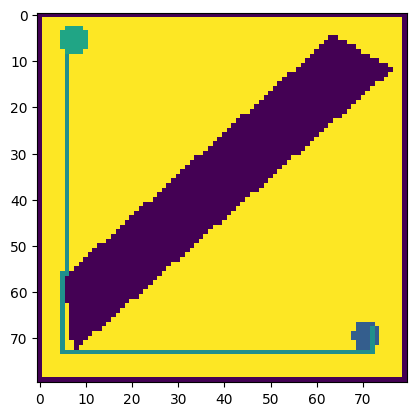

In [19]:
reader = Readbmp("content/Test0.bmp")
writer = Writebmp()
#implement the path coloring

# reader.find_and_paint_path_bfs()
# writer.writebmp("results/bfs_0_image.bmp", reader.fraction, reader.fraction, reader.matrix)

# reader.find_and_paint_path_dfs()
# writer.writebmp("results/dfs_0_image.bmp", reader.fraction, reader.fraction, reader.matrix)

reader.find_path_a_star()
writer.writebmp("results/A_Star_0_image.bmp", reader.fraction, reader.fraction, reader.matrix)

img= Image.open('results/A_Star_0_image.bmp')
result0 = img.convert(mode="L")
plt.imshow(result0)
plt.show()


![Test0](content/Test0.bmp)


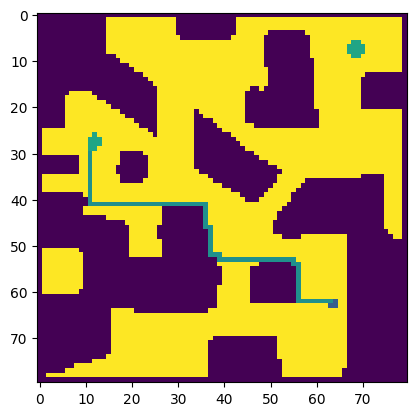

In [20]:
reader = Readbmp("content/Test1.bmp")
writer = Writebmp()

# reader.find_and_paint_path_bfs()
# writer.writebmp("results/bfs_1_image.bmp", reader.fraction, reader.fraction, reader.matrix)

# reader.find_and_paint_path_dfs()
# writer.writebmp("results/dfs_1_image.bmp", reader.fraction, reader.fraction, reader.matrix)


reader.find_path_a_star()
writer.writebmp("results/A_Star_1_image.bmp", reader.fraction, reader.fraction, reader.matrix)

img= Image.open('results/A_Star_1_image.bmp')

result1 = img.convert(mode="L")
plt.imshow(result1)
plt.show()

<!-- Ha funcionado de maravilla a excepcion de una unica imagen, donde en la cual el borde de las coordenadas como rojo o verde las pinta de negro, entonces en su totalidad no son puntos que me puedan servir para mis algoritmos como bfs, corrige eso porfavor, te muestro la imagen -->

![Test1](content/Test1.bmp)

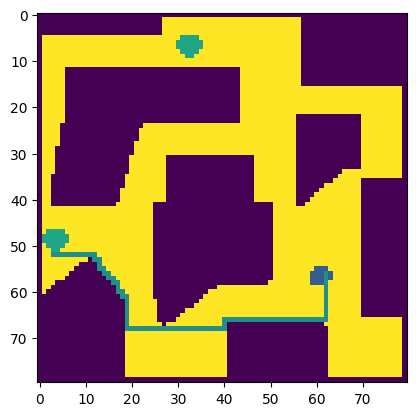

In [21]:
reader = Readbmp("content/Test2.bmp")
writer = Writebmp()

# reader.find_and_paint_path_bfs()
# writer.writebmp("results/bfs_2_image.bmp", reader.fraction, reader.fraction, reader.matrix)

# reader.find_and_paint_path_dfs()
# writer.writebmp("results/dfs_2_image.bmp", reader.fraction, reader.fraction, reader.matrix)

reader.find_path_a_star()
writer.writebmp("results/A_Star_2_image.bmp", reader.fraction, reader.fraction, reader.matrix)

img= Image.open('results/A_Star_2_image.bmp')

result2 = img.convert(mode="L")
plt.imshow(result2)
plt.show()


![Test2](content/Test2.bmp)

Referencias

* https://www.appsloveworld.com/coding/python3x/6/reading-bmp-files-in-python

*  https://favtutor.com/blogs/breadth-first-search-python